In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm

/var/folders/08/2nzzvlmn2n15r4kk5102nk6m0000gn/T/ipykernel_25115/2284576716.py:122: RuntimeWarning: overflow encountered in scalar multiply
  yp = x * (28 - z) - y + gy[t] - alpha * vy[t]
/var/folders/08/2nzzvlmn2n15r4kk5102nk6m0000gn/T/ipykernel_25115/2284576716.py:123: RuntimeWarning: overflow encountered in scalar multiply
  zp = x * y - 2.66667 * z
/var/folders/08/2nzzvlmn2n15r4kk5102nk6m0000gn/T/ipykernel_25115/2284576716.py:122: RuntimeWarning: invalid value encountered in scalar subtract
  yp = x * (28 - z) - y + gy[t] - alpha * vy[t]
/var/folders/08/2nzzvlmn2n15r4kk5102nk6m0000gn/T/ipykernel_25115/2284576716.py:127: RuntimeWarning: invalid value encountered in scalar add
  z += dt * zp


ValueError: x and y must have same first dimension, but have shapes (18,) and (26,)

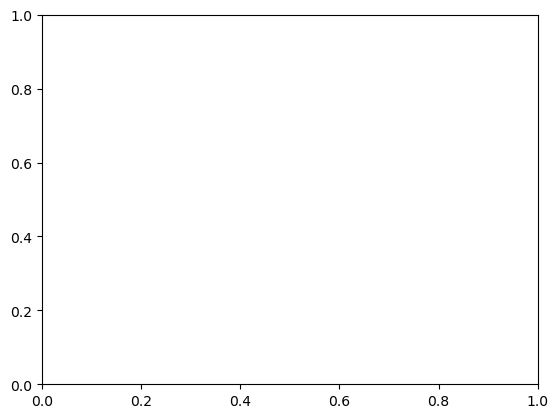

In [14]:
alphaseries = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 2, 5,
                        10, 20, 50, 70, 80, 100,
                        200, 400, 500, 1000,
                        1200, 2000, 3000, 5000, 10000, 20000, 50000])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = 10 * (y - x) + fx
    yp = x * (28 - z) - y + fy
    zp = x * y - 2.66667 * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    xross = np.zeros(ndist + 1)
    yross = np.zeros(ndist + 1)
    zross = np.zeros(ndist + 1)

    xross[0] = -7.45
    yross[0] = -3.03
    zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        xrossdot = - yross[t] - zross[t]
        yrossdot = xross[t] + 0.2 * yross[t]
        zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        xross[t + 1] = xross[t] + dt * xrossdot
        yross[t + 1] = yross[t] + dt * yrossdot
        zross[t + 1] = zross[t] + dt * zrossdot
    
        gx[t] = xross[t] * 50
        gy[t] = yross[t] * 50

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + dt / tau * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + dt / tau * (uy[t] - vy[t])

        xp = 10 * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (28 - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - 2.66667 * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = 10 * (ywithout - xwithout) 
        ypwithout = xwithout * (28 - zwithout)
        zpwithout = xwithout * ywithout - 2.66667 * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -5000:]
    pwith = pwith[:, -5000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

fig = plt.figure()
ax = plt.gca()
ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none', label = 'Distance vs alpha')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("Distance from undisturbed trajectory vs alpha")
plt.xlabel("log(alpha)")
plt.ylabel("log(distance)")
plt.show()

In [3]:
alpha

100.0

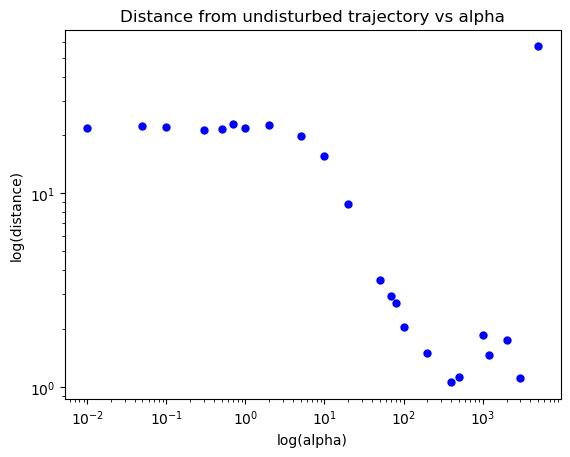

In [15]:
fig = plt.figure()
ax = plt.gca()
ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none', label = 'Distance vs alpha')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("Distance from undisturbed trajectory vs alpha")
plt.xlabel("log(alpha)")
plt.ylabel("log(distance)")
plt.show()

In [5]:
alphaseries

array([1.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 7.0e-01, 8.0e-01,
       9.0e-01, 1.0e+00, 1.0e+01, 2.0e+01, 3.0e+01, 4.0e+01, 5.0e+01,
       6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 2.0e+02, 4.0e+02,
       6.0e+02, 8.0e+02, 1.0e+03, 1.2e+03, 1.4e+03, 1.6e+03, 1.8e+03,
       2.0e+03, 2.1e+03, 2.2e+03, 2.3e+03, 2.4e+03, 2.5e+03, 2.6e+03,
       2.7e+03, 2.8e+03, 2.9e+03, 3.0e+03])

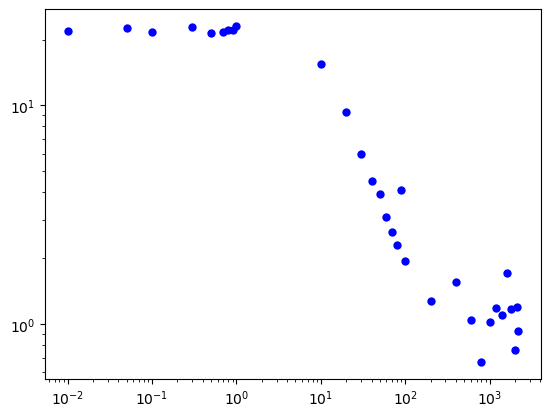

In [19]:
fig = plt.figure()
ax = plt.gca()
ax.plot(alphaseries[0:31] ,avgseries, 'o', c='blue', markeredgecolor='none')
ax.set_yscale('log')
ax.set_xscale('log')